In [38]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

In [39]:
class Continuous_PSO():
    def __init__(self, func, xlim, ylim, phi, c1, c2, total_pop = 100, total_iter = 100):
        self.func = func
        self.xlim = xlim #(a,b): a < x < b
        self.ylim = ylim #(c,d): d < y < d
        self.phi  = phi # inertia
        self.c1   = c1 # cognition constant
        self.c2   = c2  # social constant
        self.avg_history= []
        self.best_history= []

        #initiallizing swarm                                                          #randomly initializing position within bounds
        self.swarm = {'particles': [], 'global_best_val': math.inf, 'global_best_pos': np.array([random.uniform(self.xlim[0], self.xlim[1]), random.uniform(self.ylim[0], self.ylim[1])])}
        #Generating Swarm
        self.create_swarm(total_pop)
        #Running PSO
        self.PSO_solver(total_iter)


    def create_particle(self):

        # Generate a random number between the range, excluding the limits
        x = random.uniform(self.xlim[0], self.xlim[1])
        y = random.uniform(self.ylim[0], self.ylim[1])
        position = np.array([x, y])

        x_range = self.xlim[1] - self.xlim[0]
        y_range = self.ylim[1] - self.ylim[0]

        # Initializing velocity as a fraction (i.e. 10%) of the search space range
        velocity_scale = 0.1  # Can  be ajusted as needed
        vx = random.uniform(-velocity_scale * x_range, velocity_scale * x_range)
        vy = random.uniform(-velocity_scale * y_range, velocity_scale * y_range)

        velocity = np.array([vx, vy])

        personal_best_pos = position
        personal_best_val = self.func(position) # calculating fitness of the particle

        return (position, velocity, personal_best_val, personal_best_pos)

    def create_swarm(self, total_population):

        for i in range(total_population): # Generating n particles
            particle = self.create_particle() # generating single particle
            self.swarm['particles'].append(particle) # appending particles in swarm
            if particle[2] < self.swarm['global_best_val']: #checking for global best
                self.swarm['global_best_val'] = particle[2] #updating global best value
                self.swarm['global_best_pos'] = particle[3] #updating global best position


    def update_velocity(self, particle, global_best_pos):

        r1 = np.array([random.random(), random.random()])  # Separating random num for x/y for more robustness
        r2 = np.array([random.random(), random.random()])

        # updated velocity = inertia + cognitive  + social
        # inertia * current_vel + c1 * rand() * (personal_best - current_pos) + c2 * rand() * (global_best - current_pos)

        updated_velocity = self.phi * particle[1] + self.c1 * r1 * (particle[3] - particle[0]) + self.c2 * r2 * (global_best_pos - particle[0])
        return updated_velocity

    def update_position(self, pos, updated_velocity):

        # updated position = current position + updated velocity
        updated_pos = pos + updated_velocity

         # Enforcing boundaries
        updated_pos[0] = np.clip(updated_pos[0], self.xlim[0], self.xlim[1])
        updated_pos[1] = np.clip(updated_pos[1], self.ylim[0], self.ylim[1])

        return updated_pos

    def plot_best_and_avg_so_far(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.avg_history, label='Average Fitness')
        plt.plot(self.best_history, label='Best Fitness')
        plt.title("Fitness per Iteration")
        plt.xlabel("Iteration")
        plt.ylabel("Fitness Value")
        plt.legend()
        plt.grid(True)
        plt.show()


    def PSO_solver(self, total_iter, tol=1e-6, patience=10):

        total_pop = len(self.swarm['particles'])
        stagnation_counter = 0

        for j in range(total_iter):
            current_fitness = []
            for i in range(total_pop):
                # particle = (position, velocity, personal_best_val, personal_best_pos)
                particle = self.swarm['particles'][i]
                global_best_pos = self.swarm['global_best_pos']
                updated_velociity = self.update_velocity(particle, global_best_pos)
                updated_pos = self.update_position(particle[0], updated_velociity)

                val = self.func(updated_pos)
                if val < particle[2]:
                    particle = (updated_pos, updated_velociity, val, updated_pos)
                else:
                    particle = (updated_pos, updated_velociity, particle[2], particle[3])

                self.swarm['particles'][i] = particle

                if val < self.swarm['global_best_val']: # checking for global best
                    self.swarm['global_best_val'] = val #updating global best value
                    self.swarm['global_best_pos'] = updated_pos #updating global best position

                current_fitness.append(particle[2])

            self.avg_history.append(np.mean(current_fitness))
            self.best_history.append(self.swarm['global_best_val'])

            #stopping criterion: Stop if the best solution hasn’t improved for K (patience) iterations
            if len(self.best_history) > 1:
              # print("Best Solution:", self.swarm['global_best_pos'], "Best Solution Value:", self.swarm['global_best_val']
              if abs(self.best_history[-1] - self.best_history[-2]) < tol:
                  stagnation_counter += 1
                  if stagnation_counter >= patience:
                      break
              else:
                  stagnation_counter = 0

        print("Best Solution:", self.swarm['global_best_pos'], "Best Solution Value:", self.swarm['global_best_val'])
        self.plot_best_and_avg_so_far()

Best Solution: [1.01116494 1.02252186] Best Solution Value: 0.00012510910719760053


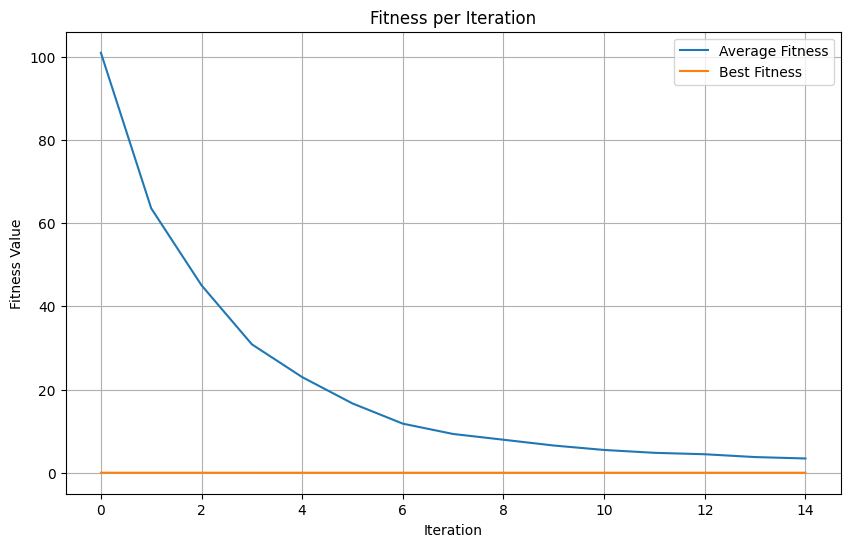

In [40]:
if __name__ == '__main__':

    # Defining the Rosenbrock function
    def function1(val):
        x, y = val
        return 100 * (x**2 - y)**2 + (1 - x)**2

    # Defining the 2d-Greiwank’s function
    def function2(val):
        x, y = val
        return 1 + (x**2 / 4000) + (y**2 / 4000) - math.cos(x) * math.cos(y / math.sqrt(2))

    phi = 0.7
    c1 = 2
    c2 = 2
    total_pop = 500
    total_iter = 100

    xlim = (-2, 2)
    ylim = (-1, 3)
    solver1 = Continuous_PSO(function1,xlim, ylim, phi, c1, c2, total_pop, total_iter)


In [41]:
# In order to verify our results we optimize using Scipy Differential Evolution (Global Optimization)
result = opt.differential_evolution(function1,
                                    bounds=[xlim, ylim],
                                    strategy='best1bin',
                                    popsize=50,        # Increase population size
                                    mutation=(0.8, 1), # More aggressive mutation
                                    recombination=0.9, # Higher crossover probability
                                    maxiter=500        # Allow more iterations
                                    )
print("Global Minimum for Function 1 using Scipy Library:", result.x, "with value:", result.fun)


Global Minimum for Function 1 using Scipy Library: [1. 1.] with value: 0.0


Best Solution: [ 0.01833467 -0.0304576 ] Best Solution Value: 0.0004002596594061547


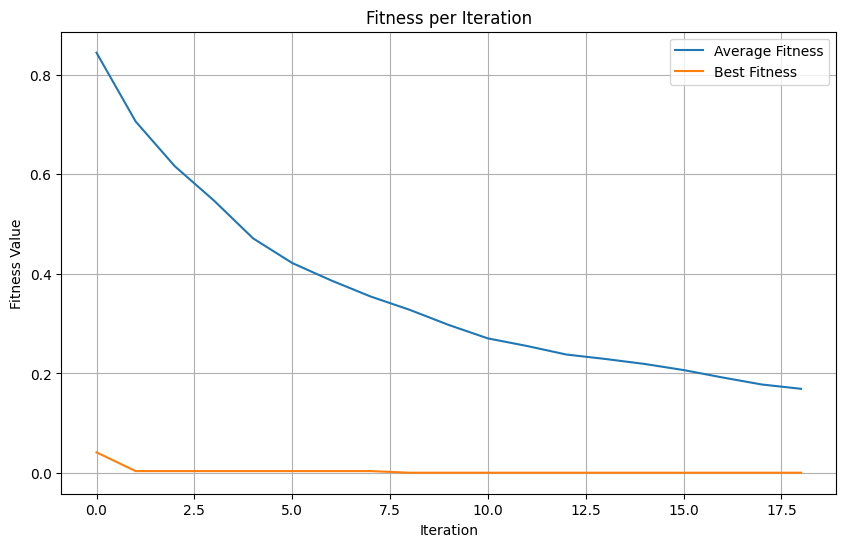

In [42]:
phi = 0.6
c1 = 1.8
c2 = 1.8
xlim = (-30, 30)
ylim = (-30, 30)
solver2 = Continuous_PSO(function2,xlim, ylim, phi, c1, c2, total_pop, total_iter)


In [43]:
# In order to verify our results we optimize using Scipy Differential Evolution (Global Optimization)
result = opt.differential_evolution(function2,
                                    bounds=[xlim, ylim],
                                    strategy='best1bin',
                                    popsize=50,        # Increase population size
                                    mutation=(0.8, 1), # More aggressive mutation
                                    recombination=0.9, # Higher crossover probability
                                    maxiter=500        # Allow more iterations
                                    )
print("Global Minimum for Function 2 using Scipy Library:", result.x, "with value:", result.fun)

Global Minimum for Function 2 using Scipy Library: [-9.25147625e-09 -1.05099396e-08] with value: 0.0


**Hence for both the Rosenbrock and 2d-Greiwank’s function the optimal value is achived, also proved using Scipy Library.**